In [7]:
import shap
import time
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.datasets import fetch_california_housing, load_digits, load_iris
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score 
import pandas as pd
import os
import pickle
import lime
from lime.lime_tabular import LimeTabularExplainer
import xgboost as xgb
import os
import matplotlib.pyplot as plt


# Notebok to analyse models 

In [8]:
os.chdir('/home/carlotaalv/Escritorio/TFM/tfm/data_models')
with open('models_final_complete.pkl', 'rb') as file:
    models_results = pickle.load(file)



/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from versi

## Load models from scik-learn

In [9]:

X_idx = models_results[4][2]
Y_idx= models_results[4][3]
model_rf =models_results[4][6]
model_knn=models_results[0][6]
model_knn_anova=models_results[1][6]
model_dt=models_results[2][6]
model_gb=models_results[3][6]


## Lime

Random Forest MSError 1.075476250111139
MSError when predicting the mean 4.6413756809306435


/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


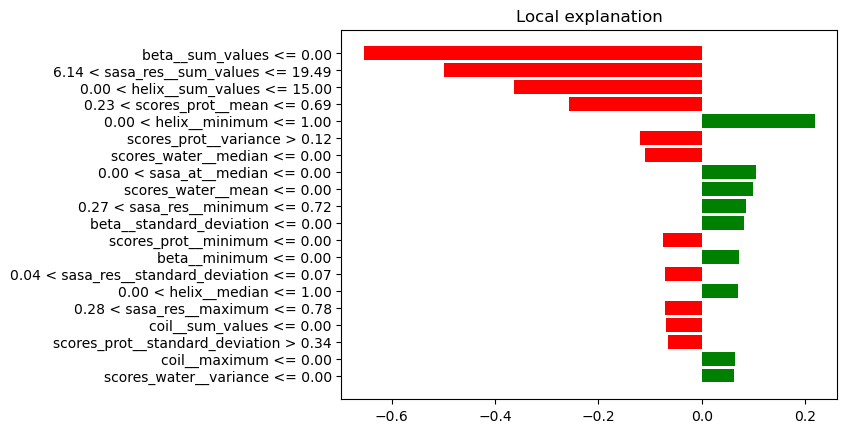

Feature: beta__sum_values <= 0.00, Contribution: -0.6535162405799384
Feature: 6.14 < sasa_res__sum_values <= 19.49, Contribution: -0.498670070687447
Feature: 0.00 < helix__sum_values <= 15.00, Contribution: -0.36406660110363254
Feature: 0.23 < scores_prot__mean <= 0.69, Contribution: -0.2572216667089838
Feature: 0.00 < helix__minimum <= 1.00, Contribution: 0.21883093363984632
Feature: scores_prot__variance > 0.12, Contribution: -0.11899192787399716
Feature: scores_water__median <= 0.00, Contribution: -0.11026357904459727
Feature: 0.00 < sasa_at__median <= 0.00, Contribution: 0.10519381008457654
Feature: scores_water__mean <= 0.00, Contribution: 0.09892171655278886
Feature: 0.27 < sasa_res__minimum <= 0.72, Contribution: 0.08583008902903505
Feature: beta__standard_deviation <= 0.00, Contribution: 0.08080399529276294
Feature: scores_prot__minimum <= 0.00, Contribution: -0.0744498202772933
Feature: beta__minimum <= 0.00, Contribution: 0.07254239036850847
Feature: 0.04 < sasa_res__standard

In [10]:
train, test, labels_train, labels_test = train_test_split(X_idx, Y_idx, train_size=0.80)
model_rf.fit(train, labels_train)
print('Random Forest MSError', np.mean((model_rf.predict(test) - labels_test) ** 2))
print('MSError when predicting the mean', np.mean((labels_train.mean() - labels_test) ** 2))
# Create LIME explainer for regression
explainer = LimeTabularExplainer(X_idx.values, feature_names=X_idx.columns, mode='regression')
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_idx.iloc[i].values, model_rf.predict, num_features=20)
exp.show_in_notebook(show_table=True)
feature_contributions = exp.as_list()
exp.as_pyplot_figure()
plt.show()  
for feature, contribution in feature_contributions:
    print(f"Feature: {feature}, Contribution: {contribution}")


## XGBOOST

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Score (MSE): -2.491970795812549
Best Parameters: {'max_depth': 4, 'n_estimators': 100}
Test Set MSE: 0.5875427845871976
Standard Deviation of Errors: 0.7663228231533263


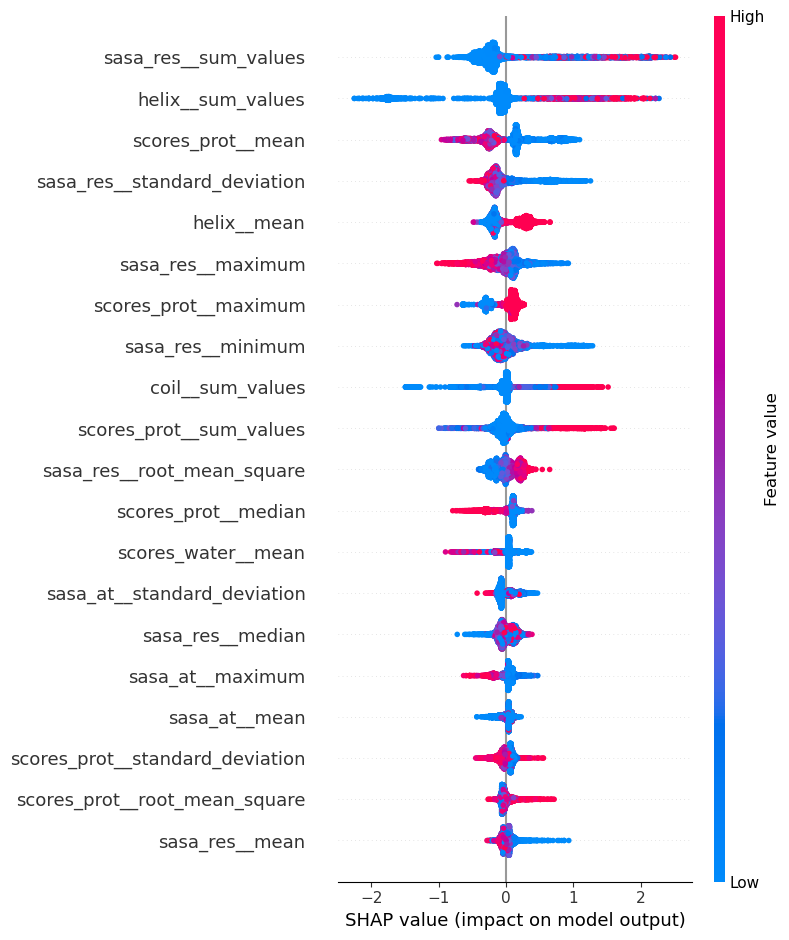

In [26]:

import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import shap

# Set random seed for reproducibility
rng = np.random.RandomState(31337)

X_train, X_test, y_train, y_test = train_test_split(X_idx, Y_idx, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_jobs=16, random_state=42)

param_grid = {
    "max_depth": [2, 3, 4], 
    "n_estimators": [50, 100]
}

# Perform Grid Search with Cross-Validation
clf = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_squared_error',  
    verbose=1,
    n_jobs=16,  
    cv=10,      
)

# Fit the model with hyperparameter tuning
clf.fit(X_idx, Y_idx)

print("Best Score (MSE):", clf.best_score_)
print("Best Parameters:", clf.best_params_)

# Get the best estimator
best_model_1 = clf.best_estimator_

# Predict on the test set
predictions = best_model_1.predict(X_test)

# Calculate Test Set MSE
test_mse = mean_squared_error(y_test, predictions)
print("Test Set MSE:", test_mse)

# Calculate Standard Deviation of Errors
errors = predictions - y_test
std_dev_errors = np.std(errors)
print("Standard Deviation of Errors:", std_dev_errors)

# SHAP Analysis for Model Interpretation
explainer = shap.Explainer(best_model_1, X_idx)  # Use optimized model
shap_values = explainer(X_idx)

# Plot SHAP Summary
shap.summary_plot(shap_values, X_idx)


In [13]:
X_halm2 = pd.read_csv('halm2_X_vals.csv')
Y_halm2 = pd.read_csv('halm2_Y_vals.csv')
print("Min y_test:", np.min(Y_halm2))
print("Max y_test:", np.max(Y_halm2))
print("Range:", np.max(Y_halm2) - np.min(Y_halm2))


Min y_test: 2.719239234449761
Max y_test: 9.97933971291866
Range: 7.2601004784689


[I 2025-01-07 04:27:50,646] A new study created in memory with name: no-name-2b980dee-9d84-4739-8a75-96bfffda75e1
/tmp/ipykernel_493862/2008638668.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),  # Log scale search
/tmp/ipykernel_493862/2008638668.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
/tmp/ipykernel_493862/2008638668.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.sugg

Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.009490601827183245, 'n_estimators': 130, 'subsample': 0.8789001728292493, 'colsample_bytree': 0.7798871197900146, 'gamma': 0.02161313025705671, 'min_child_weight': 1, 'reg_alpha': 0.0008092912897796115, 'reg_lambda': 0.007122929682002695}
Best MSE: 2.9471607324077898


 99%|===================| 6022/6057 [00:56<00:00]        

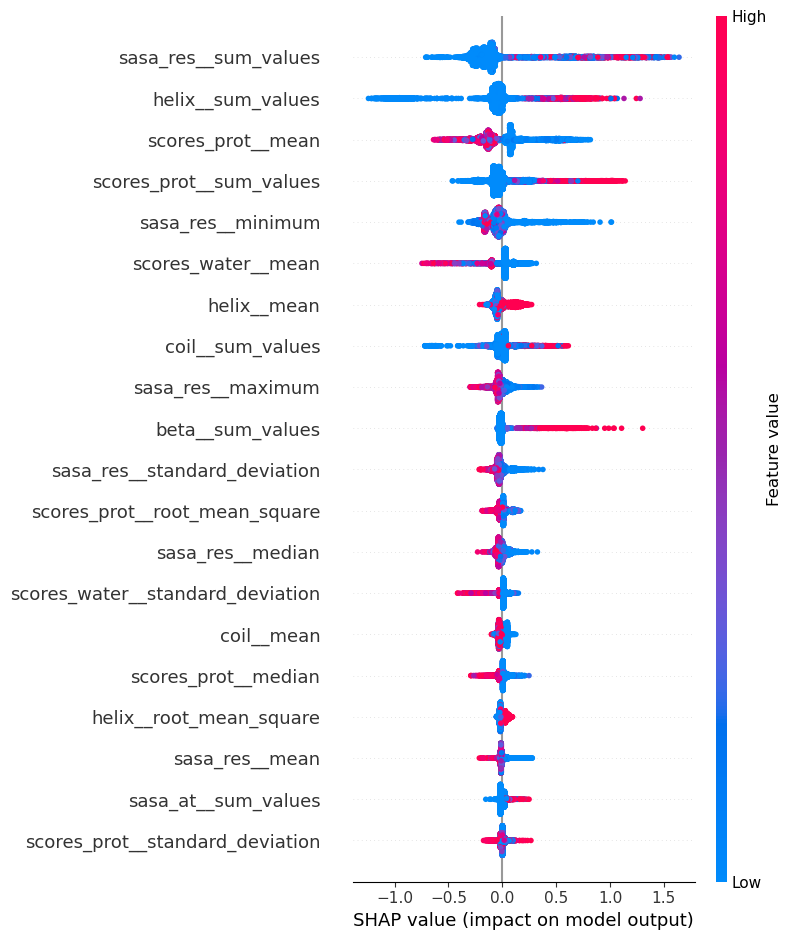

In [30]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import joblib  # To save the final model
import shap  # To explain model predictions

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),  # Integer search space
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-1),  # Log scale search
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-5, 1e-1),  # Log scale search
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1e-1),  # Log scale search
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 1e-1),  # Log scale search
    }

    # Train the XGBoost model
    model = xgb.XGBRegressor(**param, random_state=42)

    # Use cross-validation on the training data (X_idx, Y_idx)
    mse = cross_val_score(model, X_idx, Y_idx, scoring='neg_mean_squared_error', cv=5)
    
    # Return negative mean MSE as Optuna minimizes the objective
    return -mse.mean()

# Create the study object and optimize
study = optuna.create_study(direction="minimize")  # Minimize MSE
study.optimize(objective, n_trials=50)  # Perform 50 trials of optimization

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

# Train the final model with the best hyperparameters
final_model3 = xgb.XGBRegressor(**study.best_params, random_state=42)
final_model3.fit(X_idx, Y_idx)  # Train with the full training set

# SHAP Analysis
explainer = shap.Explainer(final_model3, X_idx)  # X_idx is the training data used for fitting
shap_values = explainer(X_idx)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_idx)

# Save the final model
joblib.dump(final_model, 'final_xgb_model.pkl')


### Independent test


In [31]:
X_halm2 = pd.read_csv('halm2_X_vals.csv')
Y_halm2 = pd.read_csv('halm2_Y_vals.csv')
print("Min y_test:", np.min(Y_halm2))
print("Max y_test:", np.max(Y_halm2))
print("Range:", np.max(Y_halm2) - np.min(Y_halm2))


Min y_test: 2.719239234449761
Max y_test: 9.97933971291866
Range: 7.2601004784689


In [32]:
rf_predictions=model_rf.predict(X_halm2)
knn_predictions=model_knn.predict(X_halm2)
knn_anova_predictions=model_knn_anova.predict(X_halm2)
gb_predictions=model_gb.predict(X_halm2)
dt_predictions=model_dt.predict(X_halm2)
xgboost_predicitons=final_model3.predict(X_halm2) #with optuna
otro=best_model_1.predict(X_halm2) 


/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/carlotaalv/mambaforge/envs/ml/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate models
models = {
    "KNN": knn_predictions,
    "KNN with ANOVA": knn_anova_predictions,
    "Decision Tree": dt_predictions,
    "Gradient Boosting": gb_predictions,
    "Random Forest": rf_predictions,
    "XGBoost": xgboost_predicitons,
    "otro":otro
}

# Calculate metrics for each model
for name, predictions in models.items():
    mse = mean_squared_error(Y_halm2, predictions)
    mae = mean_absolute_error(Y_halm2, predictions)
    rmse = np.sqrt(mse)
    
    print(f"\n{name}:")
    print(f"  - Mean Squared Error (MSE): {mse:.2f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")



KNN:
  - Mean Squared Error (MSE): 6.01
  - Mean Absolute Error (MAE): 1.99
  - Root Mean Squared Error (RMSE): 2.45

KNN with ANOVA:
  - Mean Squared Error (MSE): 5.75
  - Mean Absolute Error (MAE): 1.95
  - Root Mean Squared Error (RMSE): 2.40

Decision Tree:
  - Mean Squared Error (MSE): 5.64
  - Mean Absolute Error (MAE): 1.92
  - Root Mean Squared Error (RMSE): 2.37

Gradient Boosting:
  - Mean Squared Error (MSE): 6.58
  - Mean Absolute Error (MAE): 2.12
  - Root Mean Squared Error (RMSE): 2.57

Random Forest:
  - Mean Squared Error (MSE): 5.83
  - Mean Absolute Error (MAE): 1.93
  - Root Mean Squared Error (RMSE): 2.42

XGBoost:
  - Mean Squared Error (MSE): 4.22
  - Mean Absolute Error (MAE): 1.65
  - Root Mean Squared Error (RMSE): 2.06

otro:
  - Mean Squared Error (MSE): 4.67
  - Mean Absolute Error (MAE): 1.74
  - Root Mean Squared Error (RMSE): 2.16
